In [132]:
import torch
import torch.nn as nn
from d2l import torch as d2l
import pandas as pd
import os
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.nn.functional import gumbel_softmax, one_hot
from torch import argmax
from collections import Counter

import numpy as np

In [2]:
d2l.DATA_HUB['ml-100k'] = (
    'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

#@save
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), sep='\t',
                       names=names, engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

data = read_data_ml100k()
data[0]["rating"].mean()

3.52986

In [3]:
def get_user_histories():
    data, num_users, num_items = read_data_ml100k()

    user_histories = {"user_id": [], "history": []}

    for user_id, group in data.groupby('user_id'):
        group = group.sort_values(by="timestamp")

        user_histories["user_id"].append(user_id)
        user_histories["history"].append(group["item_id"].to_list())

    return pd.DataFrame(user_histories), num_users, num_items

def get_loader(histories, max_history_len, batch_size):
    X = []
    y = []
    
    for idx, row in histories.iterrows():
        ids = [0 for i in range(max_history_len)]
        
        for i in range(len(row["history"]) - 1):
            ids[i] = row["history"][i]
        
        X.append(ids)
        y.append(row["history"][-1])

    X = np.array(X)
    y = np.array(y)

    print(X.shape, y.shape)

    tensor_dataset = TensorDataset(
        torch.tensor(X),
        torch.tensor(y)
    )

    print("batch_size", batch_size)
    
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    return loader

def get_train_test_loaders(batch_size=64, test_size=0.1):
    user_histories, num_users, num_items = get_user_histories()

    train_users = set(user_histories["user_id"].sample(frac=1 - test_size, random_state=137).to_list())
    test_users  = set(range(1, num_users + 1)).difference(train_users)

    train_histories = user_histories[user_histories["user_id"].isin(train_users)]
    test_histories = user_histories[user_histories["user_id"].isin(test_users)]

    max_history_len = max(
        train_histories["history"].apply(lambda x: len(x)).max(),
        test_histories["history"].apply(lambda x: len(x)).max()
    )

    print("max_history_len", max_history_len)

    train_laoder = get_loader(train_histories, max_history_len, batch_size)
    test_laoder = get_loader(test_histories, max_history_len, batch_size)

    return train_laoder, test_laoder, num_users, num_items


In [177]:
train_loader, test_loader, num_users, num_items = get_train_test_loaders(batch_size=8, test_size=0.1)

for _ in train_loader:
    print(_)
    break

num_users, num_items

max_history_len 737
(849, 737) (849,)
batch_size 8
(94, 737) (94,)
batch_size 8
[tensor([[286, 258, 321,  ...,   0,   0,   0],
        [313, 286, 333,  ...,   0,   0,   0],
        [316, 313, 302,  ...,   0,   0,   0],
        ...,
        [255, 286, 298,  ...,   0,   0,   0],
        [181,  28, 651,  ...,   0,   0,   0],
        [300,   1, 258,  ...,   0,   0,   0]]), tensor([1052,  833,  780,   50, 1035,  271,  318,  434])]


(943, 1682)

In [178]:
class IntentModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_intents, befor_clustering_shape):
        super().__init__()
        # Эмбеддинги айтемов
        self.items = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        self._num_intents = num_intents
        self.intents = nn.Embedding(num_intents, embedding_dim, padding_idx=0)

        # Отображение в интенты
        # ...
        # ...
        self.clustering1 = nn.Linear(embedding_dim, befor_clustering_shape)
        self.clustering2 = nn.ReLU()
        self.clustering3 = nn.Linear(befor_clustering_shape, num_intents)
        self.clustering4 = nn.ReLU()
        # ...

        # Отображение векторов интентов в эмбеддинги
        # self.linear = nn.Linear(
        #     in_features=embedding_dim,
        #     out_features=num_embeddings,
        # )

    def forward(self, x):
        # Матрица векторов айтемов, с которым провзаимодействовал пользователь
        x = self.items(x)

        # Распределение айтемов из истории по интентам
        intents = self.clustering1(x)
        intents = self.clustering2(intents)
        intents = self.clustering3(intents)
        intents = self.clustering4(intents)

        # Вектора интентов для текущего юзера
        intents = torch.bmm(intents.mT, x)
        output = intents

        return output

In [179]:
# model = IntentModel(1682, 4, 5)

# for (X, y) in train_loader:
#     # model(X)
#     print(model(X))
#     break

In [180]:
# def calculate_loss(net, iter):
#     criterion = nn.CrossEntropyLoss()

#     loss_ = 0
#     total = 0

#     for idx, (tokens, target) in enumerate(iter):
#         loss_ += criterion(net(tokens), target).item()
#         total   += target.size()[0]

#     return loss_ / total

def calculate_diversity(net, iter):
    mean_diversity = 0
    total          = 0
    
    for idx, (tokens, target) in enumerate(iter):
        intents = net(tokens)
        predictions = torch.matmul(intents, net.items.weight.T[:, :]).detach().numpy()
        target = target.detach().numpy()
        top_n_recos_by_intent = np.argpartition(predictions, -4, axis=2)[:,:,:5]

        for top_recos, target in zip(top_n_recos_by_intent, target):
            top_recos = top_recos.flatten()
            counter = Counter(top_recos)

            count = sum(count for n, count in counter.items())
            mean = count / len(counter)

            mean_diversity += mean
            total += 1
    return mean_diversity / total

def calculate_accuracy(net, iter):
    correct = 0
    total   = 0

    for idx, (tokens, target) in enumerate(iter):
        intents = net(tokens)
        predictions = torch.matmul(intents, net.items.weight.T[:, :])
        predictions = predictions.detach().numpy()
        target = target.detach().numpy()

        top_n_recos_by_intent = np.argpartition(predictions, -4, axis=2)[:,:,:5]

        for top_recos, target in zip(top_n_recos_by_intent, target):
            top_recos = top_recos.flatten()
            

            correct += int(target in top_recos)
            total += 1

    return correct / total

In [181]:
num_embeddings = num_items + 1
embedding_dim = 16
num_intents = 5

model = IntentModel(num_embeddings, embedding_dim, num_intents, 8)
# loss_func = torch.nn.CrossEntropyLoss()
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 20

train_loss = []
train_accuracy = []
test_loss  = []
test_accuracy = []

train_diversity = []
test_diversity = []

is_val = True

print(model)

for epoch in range(num_epochs):

    batch_losses = []
    
    for idx, (tokens, target) in enumerate(train_loader):
        optimizer.zero_grad()
        prediction = model(tokens)
        target_embeddings = model.items(target)
        logits = torch.bmm(prediction, target_embeddings[:, :, None])
        best_intents = argmax(logits, dim=1)
        best_intents = one_hot(best_intents, num_classes=num_intents).reshape(logits.shape).float()

        print(logits)
        print(best_intents)

        3/""

        loss = loss_func(logits, best_intents)
        batch_losses.append(loss.detach())
        loss.backward()
        
        optimizer.step()

    train_loss.append(sum(batch_losses) / len(batch_losses))
    train_accuracy.append(calculate_accuracy(model, train_loader))
    train_diversity.append(calculate_diversity(model, train_loader))
    # test_loss.append(calculate_loss(model, test_loader))
    test_accuracy.append(calculate_accuracy(model, test_loader))
    test_diversity.append(calculate_diversity(model, test_loader))

    if is_val:
        print("Epoch:", epoch)
        # print("Train loss", train_loss[-1])
        print("Train accuracy", train_accuracy[-1])
        print("Train diversity", train_diversity[-1])
        # print("Test loss", test_loss[-1])
        print("Test accuracy", test_accuracy[-1])

IntentModel(
  (items): Embedding(1683, 16, padding_idx=0)
  (intents): Embedding(5, 16, padding_idx=0)
  (clustering1): Linear(in_features=16, out_features=8, bias=True)
  (clustering2): ReLU()
  (clustering3): Linear(in_features=8, out_features=5, bias=True)
  (clustering4): ReLU()
)
tensor([[[-10.6866],
         [-18.6126],
         [ 21.3014],
         [-55.9879],
         [-40.8017]],

        [[ -4.9682],
         [-35.7328],
         [-67.3611],
         [-33.3146],
         [-54.3871]],

        [[  0.7677],
         [ 10.1933],
         [  1.8943],
         [ -2.3617],
         [ 11.9120]],

        [[  0.0000],
         [  7.3546],
         [ 14.8135],
         [ -0.1781],
         [  6.4798]],

        [[ -0.1206],
         [  6.9207],
         [  9.1463],
         [ -3.2519],
         [ -6.0410]],

        [[  0.0000],
         [ -2.8437],
         [-15.7640],
         [  0.2639],
         [-19.2408]],

        [[ -0.4516],
         [ -6.4917],
         [ -5.5603],
        

TypeError: unsupported operand type(s) for /: 'int' and 'str'

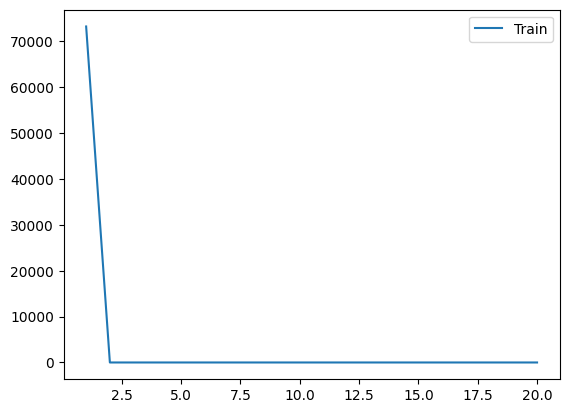

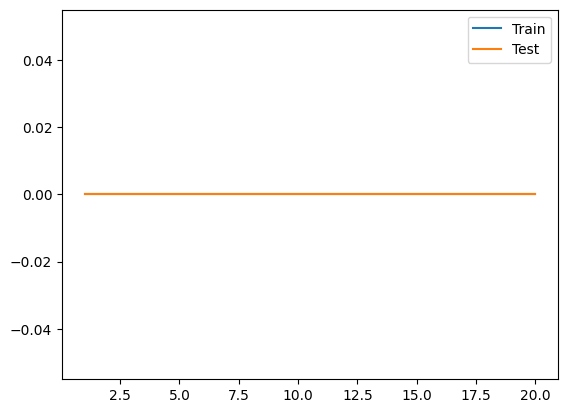

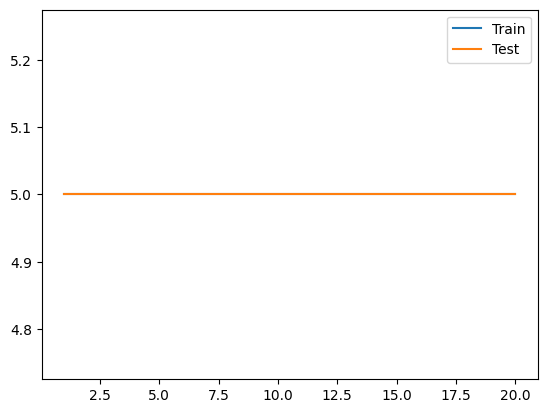

In [175]:
import matplotlib.pyplot as plt 

x = list(range(1, num_epochs + 1))

plt.plot(x, train_loss, label="Train")
# plt.plot(x, test_loss, label = "Test")
plt.legend(loc='best')
plt.show()

plt.plot(x, train_accuracy, label="Train")
plt.plot(x, test_accuracy, label = "Test")
plt.legend(loc='best')
plt.show()

plt.plot(x, train_diversity, label="Train")
plt.plot(x, test_diversity, label = "Test")
plt.legend(loc='best')
plt.show()